# My Frist NLP and Jupyter NB

For this Natural Language processor, I am using the following Libraries : SPACY

Data: from kaggle exercise : 
>restaurant.json, yelp_ratings.csv
   

This book is emulating a kaggle exercise i have done before. Idea is to find the best rated and worst rated menu items based on the reviews.

### Facts:
  1. restaurant data has only this client's data - This restaurant only
  2. ratings data are basically customers rating menu items of this particular restaurant.

## The Ask

Ask the client what they want to know? 

In this case they want to konw how customers have rated menu items in Yelp. They have reviews from Yelp and they have a menu. They wanted to know best and worst items to they can optimize.

#### Lets Look at data to see what we need to work with.

In [1]:
# Author: Manu Nellutla
# date : 07/4/2020
# file:  food_ratings_with_NLP
# Desc:  Finding best and worst rated menu items for a restaurant.

#starting with importing pandas to read data 
import pandas as pd

restaurant_data = pd.read_json("data/yelp_restaurant.json")

#lets see what its features or dimensions it has 
restaurant_data.info()

#let's see few rows
restaurant_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1321 entries, 109 to 644757
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    1321 non-null   object        
 1   user_id      1321 non-null   object        
 2   business_id  1321 non-null   object        
 3   stars        1321 non-null   int64         
 4   useful       1321 non-null   int64         
 5   funny        1321 non-null   int64         
 6   cool         1321 non-null   int64         
 7   text         1321 non-null   object        
 8   date         1321 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 103.2+ KB


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
109,lDJIaF4eYRF4F7g6Zb9euw,lb0QUR5bc4O-Am4hNq9ZGg,r5PLDU-4mSbde5XekTXSCA,4,2,0,0,I used to work food service and my manager at ...,2013-01-27 17:54:54
1013,vvIzf3pr8lTqE_AOsxmgaA,MAmijW4ooUzujkufYYLMeQ,r5PLDU-4mSbde5XekTXSCA,4,0,0,0,We have been trying Eggplant sandwiches all ov...,2015-04-15 04:50:56
1204,UF-JqzMczZ8vvp_4tPK3bQ,slfi6gf_qEYTXy90Sw93sg,r5PLDU-4mSbde5XekTXSCA,5,1,0,0,Amazing Steak and Cheese... Better than any Ph...,2011-03-20 00:57:45
1251,geUJGrKhXynxDC2uvERsLw,N_-UepOzAsuDQwOUtfRFGw,r5PLDU-4mSbde5XekTXSCA,1,0,0,0,Although I have been going to DeFalco's for ye...,2018-07-17 01:48:23
1354,aPctXPeZW3kDq36TRm-CqA,139hD7gkZVzSvSzDPwhNNw,r5PLDU-4mSbde5XekTXSCA,2,0,0,0,"Highs: Ambience, value, pizza and deserts. Thi...",2018-01-21 10:52:58



#### Working with inputs - Menu data

Looks like one solution is to look for keywords in item reviews and see if we can match it with any menu items. If there is a match then good. 

***Assumptions / Limitation***
1. Text in reviews are on menu based dishes.
2. Reviews with generalized reviews will mostly be ignored for no match.

So,whatever was given we converted it to a list and called it "Menu". Apart from item names in the menu, It is a good idea to use common names or commonly used terms. 
>E.g: "Cheese Steak", "Cheesesteak", "Steak and Cheese".

That way the more better we might find. 

Ultimately at somepoint of time we might try to ***lemmatize*** the words for better matching - Look up lemmatize.

In [2]:
# These are menu items from the restaurant. We will finally find the best and word of this list.
menu = ["Cheese Steak", "Cheesesteak", "Steak and Cheese", "Italian Combo", "Tiramisu", "Cannoli",
        "Chicken Salad", "Chicken Spinach Salad", "Meatball", "Pizza", "Pizzas", "Spaghetti",
        "Bruchetta", "Eggplant", "Italian Beef", "Purista", "Pasta", "Calzones",  "Calzone",
        "Italian Sausage", "Chicken Cutlet", "Chicken Parm", "Chicken Parmesan", "Gnocchi",
        "Chicken Pesto", "Turkey Sandwich", "Turkey Breast", "Ziti", "Portobello", "Reuben",
        "Mozzarella Caprese",  "Corned Beef", "Garlic Bread", "Pastrami", "Roast Beef",
        "Tuna Salad", "Lasagna", "Artichoke Salad", "Fettuccini Alfredo", "Chicken Parmigiana",
        "Grilled Veggie", "Grilled Veggies", "Grilled Vegetable", "Mac and Cheese", "Macaroni",  
         "Prosciutto", "Salami"]


#### Setting up for NLP
Now that we have the basics down... Let's start with the setup

In [3]:
#import spacy library
import spacy

#lets start with loading which language model we want to use -> look up language models for NLP
# we prefer Engish

nlp_en_model = spacy.blank('en')



Since we are starting lets analyse 1 review. "Getting our ducks in row" before the big finish

In [4]:
# picking one review to work with. Getting row number 14.
test_review = restaurant_data.text.iloc[14]

#print and see what it lookw like -> py notebooks don't need explicit print() verb to print
test_review



"The Il Purista sandwich has become a staple of my life. Mozzarella, basil, prosciutto, roasted red peppers and balsamic vinaigrette blend into a front runner for the best sandwich in the valley. Goes great with sparkling water or a beer. \n\nDeFalco's also has other Italian fare such as a delicious meatball sub and classic pastas."


Those are lot of words. We need to tokenize them {make them a list of words instead of sentences}. Lets play with "SPACY" to see what it can do for us. 2 features i read are
> 1. 'LEMMATIZING'{token.lemma_ : Claming -> calm}
>2. 'FINDING NOISE" {token.is_stop : words - like "is", "the" etc..}

### Tokenize is the keyword

Tokenize also separates all non characters/symbols too. '.' ',' '?'

In [5]:
#tokenize -> using nlp language model defined in steps before.

review_words = nlp_en_model(test_review) # this is a tokenized doc object.

#uncoment line below to see how words are tokenized - printing as a list.
#print([word for word in review_words])

#heading for our table -> uncomment lines below


print(f"Token \t\tLemma \t\tStopword".format('Token', 'Lemma', 'Stopword'))
print("-"*40)  # just a separator "-----"

for token in review_words:
    print(f"{str(token)}\t\t{token.lemma_}\t\t{token.is_stop}")

Token 		Lemma 		Stopword
----------------------------------------
The		The		True
Il		Il		False
Purista		Purista		False
sandwich		sandwich		False
has		has		True
become		become		True
a		a		True
staple		staple		False
of		of		True
my		my		True
life		life		False
.		.		False
Mozzarella		Mozzarella		False
,		,		False
basil		basil		False
,		,		False
prosciutto		prosciutto		False
,		,		False
roasted		roasted		False
red		red		False
peppers		peppers		False
and		and		True
balsamic		balsamic		False
vinaigrette		vinaigrette		False
blend		blend		False
into		into		True
a		a		True
front		front		True
runner		runner		False
for		for		True
the		the		True
best		best		False
sandwich		sandwich		False
in		in		True
the		the		True
valley		valley		False
.		.		False
Goes		Goes		False
great		great		False
with		with		True
sparkling		sparkling		False
water		water		False
or		or		True
a		a		True
beer		beer		False
.		.		False


		

		False
DeFalco		DeFalco		False
's		's		True
also		also		True
has		has		True
other		other


### Matcher setup

Lets get serious now... First setup a matcher then match and collect. PhraseMatcher is a method offered by SPACY library which matches your ***pattern*** list of words in the target string.

In [6]:
#lets import phrasematcher from spacy
from spacy.matcher import PhraseMatcher

# Create the PhraseMatcher object. The tokenizer is the first argument. Use attr = 'LOWER' to make consistent capitalization
matcher = PhraseMatcher(nlp_en_model.vocab, attr='LOWER')

# Create a list of tokens for each item in the menu
menu_tokens_list = [nlp_en_model(item) for item in menu]

#this is a small method to catch what is matched and not.
def on_match(matcher, doc, id, matches):
      print(f"Token number {matches[id]} : {review_words[matches[id][1]:matches[id][2]]}")

# Add the item patterns to the matcher. 
# Look at https://spacy.io/api/phrasematcher#add in the docs for help with this step
# Then uncomment the lines below 

# 
matcher.add("MENU",            # Just a name for the set of rules we're matching to
           on_match,              # Special actions to take on matched words
           *menu_tokens_list  
          )

# Find matches in the review_doc
matches = matcher(review_words)




Token number (8291075388056826051, 2, 3) : Purista
Token number (8291075388056826051, 16, 17) : prosciutto
Token number (8291075388056826051, 58, 59) : meatball


### Working with Main Dataset

Now that we run our model on full dataset.

In [8]:
from collections import defaultdict

# item_ratings is a dictionary of lists. If a key doesn't exist in item_ratings,
# the key is added with an empty list as the value.
item_ratings = defaultdict(list)

# lets redo our matcher to not use 'on_match' action
matcher.add("MENU",            # Just a name for the set of rules we're matching to
           None,              # Special actions to take on matched words
           *menu_tokens_list  
          )

it = []
for idx, review in restaurant_data.iterrows():
    doc = nlp_en_model(review.text)
    # Using the matcher from the previous exercise
    matches = matcher(doc)
    
    # Create a set of the items found in the review text
    found_items = set([doc[match[1]:match[2]] for match in matches])
    
    # Update item_ratings with rating for each item in found_items
    # Transform the item strings to lowercase to make it case insensitive
    for item in found_items:
        item_ratings[str(item).lower()].append(review.stars)


,item,avg_rating,rating_cnt
0,chicken parmigiana,4.444444,18
1,eggplant,3.968421,95
2,steak and cheese,4.888889,9
3,pizza,4.304469,358
4,meatball,4.079755,163


#### Extract results and plot

Lets extract results into a final managable datasets and lets plot some graphs


In [45]:
#variable to hold our extracted data
final_list = []

# calculate make sure we have enought data to capture
for item, ratings in item_ratings.items():
    final_list.append({
        'item' : item,
        'avg_rating' : sum(ratings)/len(ratings),
        'rating_cnt' : len(ratings)
    })

#Mkae a final dataframe for analysis.
fin_df = pd.DataFrame(final_list)

fin_df.head()




,item,avg_rating,rating_cnt
0,chicken parmigiana,4.444444,18
1,eggplant,3.968421,95
2,steak and cheese,4.888889,9
3,pizza,4.304469,358
4,meatball,4.079755,163



#### Plotting results

Barchart of reviews count vs item

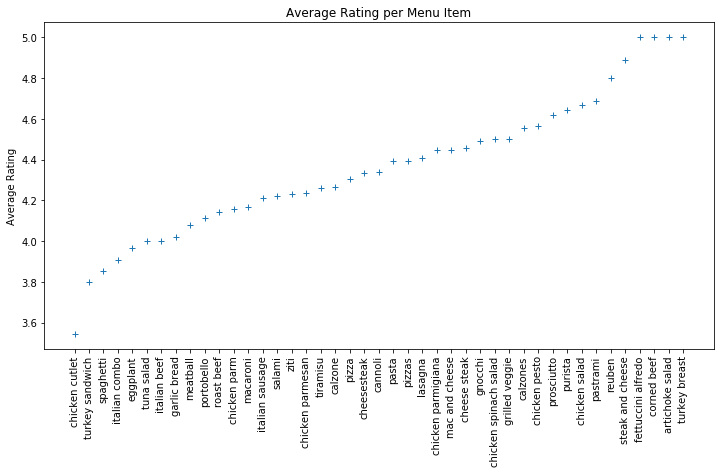

In [40]:
# lets plot some graphs
import matplotlib.pyplot as plt
fin_df = fin_df.sort_values(by=['avg_rating'], ascending=True)
plt.figure(figsize=(12,6))
plt.plot(fin_df.item,fin_df.avg_rating, '+')
plt.title('Average Rating per Menu Item')
plt.ylabel('Average Rating')
plt.xticks(fin_df.item, rotation='vertical')
pass

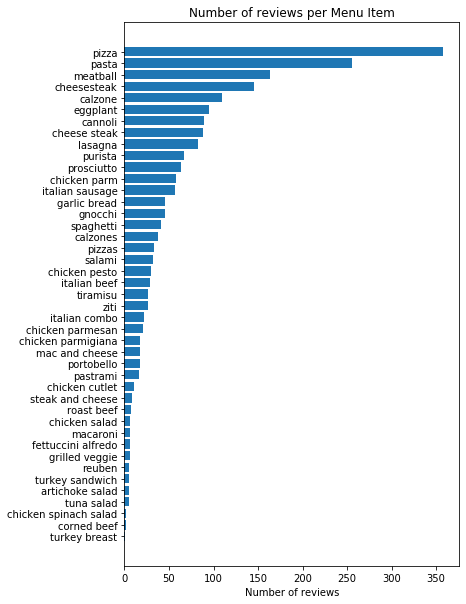

In [44]:
fin_df = fin_df.sort_values(by=['rating_cnt'], ascending=True)
plt.figure(figsize=(6,10))
plt.barh(fin_df.item,fin_df.rating_cnt)
plt.title('Number of reviews per Menu Item')
plt.xlabel('Number of reviews')
pass